** Dataset used for analysis was acquired through a web scrapper script given in the following URL**

Web Scrapper: https://colab.research.google.com/drive/1g3V4XpWj2FwLgZUikrEkFsH4EP4TRBRP?usp=sharing

Import Datasets

In [2]:
import numpy as np
import pandas as pd
from numpy import zeros
import tensorflow as tf
# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

# split data into train and test set
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('reviews_1.csv', engine='python')
df2 = pd.read_csv('reviews_2.csv', engine='python')
df3 = pd.read_csv('reviews_3.csv', engine='python')

Add Header

In [4]:
columns = ['Movie Name', 'Critic Score', 'Audience Score', 'Reviewer', 'Review Text']
df.columns = columns
df2.columns = columns
df3.columns = columns

In [5]:
df = df.append(df2)
df = df.append(df3)

In [6]:
df.describe()

,Critic Score,Audience Score
count,106215.000000,98887.000000
mean,71.639495,65.286175
std,25.037741,19.953200
min,0.000000,0.000000
25%,57.000000,51.000000
50%,80.000000,68.000000
75%,92.000000,81.000000
max,100.000000,100.000000


In [7]:
df.Reviewer.value_counts()

critic      74708
audience    34176
Name: Reviewer, dtype: int64

### We have more Critic Reviews than Audience Reviews.

Since Rotten Tomatoes Separates both the critic scores and audience score. We will also Train our model only based on Critic Reviews 

In [8]:
# Select Critic Reviews Only
critic_reviews = df.loc[df['Reviewer'] == "critic"]

In [9]:
# Creating a new dataframe with text reviews and the percentage score
critic_reviews = critic_reviews[["Review Text", "Critic Score"]]
critic_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74708 entries, 0 to 84507
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Review Text   74708 non-null  object 
 1   Critic Score  73344 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.7+ MB


In [10]:
# Droping all rows with empty values
critic_reviews = critic_reviews.dropna()
critic_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73344 entries, 1 to 84491
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Review Text   73344 non-null  object 
 1   Critic Score  73344 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.7+ MB


In [11]:
# Turning percentile score into ratings from 1 to 5
df_new = critic_reviews.reset_index()
score = df_new['Critic Score']
rating = []
print(score[1])
for i in range(len(score)):
  if score[i] <= 100 and score[i] >= 81:
    rating.append(5)
  elif score[i] <= 80 and score[i] >= 61:
    rating.append(4)
  elif score[i] <= 60 and score[i] >= 41:
    rating.append(3)
  elif score[i] <= 40 and score[i] >= 21:
    rating.append(2)
  elif score[i] <= 20 and score[i] >= 0:
    rating.append(1)
  else:
    rating.append(3)

df_new['rating'] = rating
df_new = df_new.drop(['Critic Score'], axis=1)
df_new.head()

93.0


,index,Review Text,rating
0,1,\r\nOn the strength of its performances and ov...,5
1,2,\r\nWill get passed around between teenage gir...,5
2,3,\r\nTracey Deer uses her background as a docum...,5
3,4,\r\nDeer lays out an incredible arc of self-di...,5
4,5,\r\nAn eye-opening and compelling story about ...,5


# Cleaning Reviews

Install Stop words to remove unnecessary words such as and, an, what.

In [12]:
!python -m nltk.downloader stopwords
!python -m nltk.downloader averaged_perceptron_tagger
!python -m nltk.downloader wordnet

C:\Users\ALU STUDENT\anaconda3\lib\runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to C:\Users\ALU
[nltk_data]     STUDENT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\ALU STUDENT\anaconda3\lib\runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ALU STUDENT\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
C:\Users\ALU STUDENT\anaconda3\lib\runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after i

In [13]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # Remove first two characters that appear on all reviews
    text = text[2:]
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# Method to Clean all Reviews
df_new["Review Text"] = df_new["Review Text"].apply(lambda x: clean_text(x))

In [14]:
df_new.head()

,index,Review Text,rating
0,1,strength performance overall filmmaking bean s...,5
1,2,get pass around teenage girl way judy blume bo...,5
2,3,tracey deer us background documentary filmmake...,5
3,4,deer lay incredible arc self-discovery bean jo...,5
4,5,eye-opening compel story weight oppression rac...,5


In [15]:
df_new['rating'].value_counts()

5    36632
4    17053
3     9771
2     6011
1     3877
Name: rating, dtype: int64

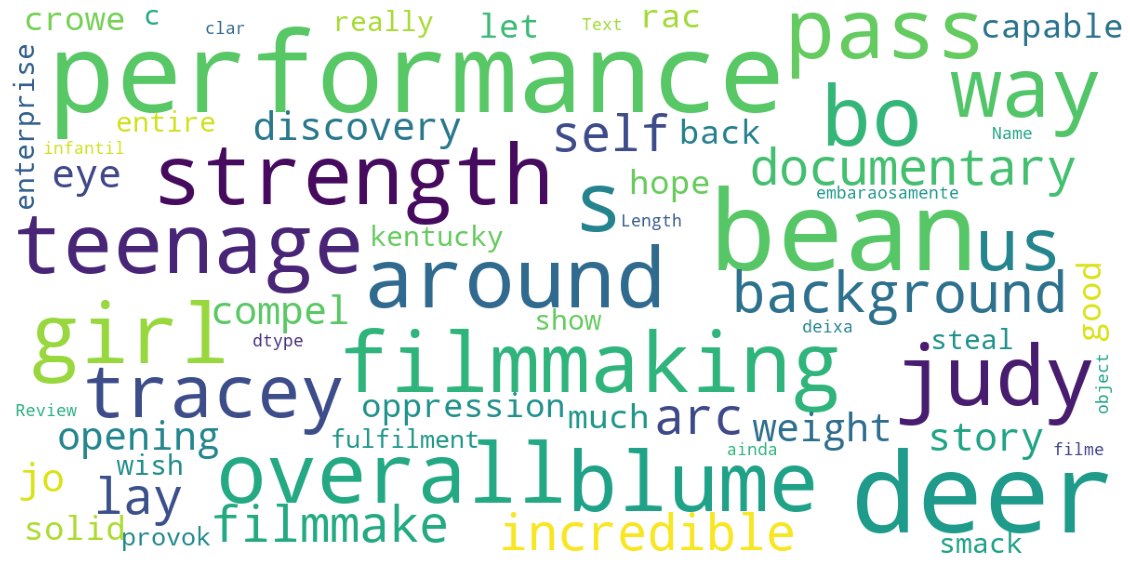

In [16]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df_new["Review Text"])

As you can see most of the words used in the review are film related

Split Data into Training and Testing

In [17]:
X = df_new['Review Text'].values
y = df_new['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)
vocab_size = len(t.word_index) + 1

In [19]:
# integer encode the documents
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)
print(encoded_train[0:2])

[[277, 128, 2, 235, 1062, 184, 89, 728, 2560, 1], [32, 218, 793, 352, 2126, 18053, 14939, 212, 18054, 1635, 1822, 1010, 1315, 6438, 109, 3269, 351, 2501, 356, 556, 385, 1]]


In [64]:
# pad documents to a max length of 6 words
max_length = 6
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
print(padded_test)

[[  441  1411    73  6497   670     1]
 [   72     2   190   301   955  1610]
 [10132   984   508   178 18981     1]
 ...
 [  391  5874     2     1     0     0]
 [ 2047   404     8     9    10     1]
 [  863   465 17135   142    98     1]]


In [23]:
!wget http://nlp.stanford.edu/data/glove.6B.zip --no-check-certificate

--2021-04-10 00:02:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-10 00:02:21--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
Unable to establish SSL connection.


In [24]:
!unzip glove*.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [31]:
!ls
!pwd

drive		   glove.6B.200d.txt  glove.6B.50d.txt	sample_data
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
/content


In [65]:
# load the whole embedding into memory
embeddings_index = {}
f = open('glove.6B/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector 

Loaded 400000 word vectors.


# Model

In [75]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=6, trainable=False)
model.add(e)
model.add(LSTM(1))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
opt = Adam(lr = 0.0001)
model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 6, 100)            4016400   
_________________________________________________________________
lstm_8 (LSTM)                (None, 1)                 408       
_________________________________________________________________
dropout_7 (Dropout)          (None, 1)                 0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 1)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 2         
Total params: 4,016,810
Trainable params: 410
Non-trainable params: 4,016,400
_________________________________________________________________


In [76]:
#Fitting the data into the model
model.fit(padded_train, y_train, epochs=100, verbose=1)

Epoch 1/100
1719/1719 [==============================] - 7s 3ms/step - loss: -0.2646 - accuracy: 0.0451
Epoch 2/100
1719/1719 [==============================] - 5s 3ms/step - loss: -2.4886 - accuracy: 0.0515
Epoch 3/100
1719/1719 [==============================] - 5s 3ms/step - loss: -3.7175 - accuracy: 0.0499
Epoch 4/100
1719/1719 [==============================] - 5s 3ms/step - loss: -4.8940 - accuracy: 0.0523
Epoch 5/100
1719/1719 [==============================] - 4s 3ms/step - loss: -6.0585 - accuracy: 0.0528
Epoch 6/100
1719/1719 [==============================] - 5s 3ms/step - loss: -7.2595 - accuracy: 0.0521
Epoch 7/100
1719/1719 [==============================] - 5s 3ms/step - loss: -8.5842 - accuracy: 0.0531
Epoch 8/100
1719/1719 [==============================] - 4s 3ms/step - loss: -10.1685 - accuracy: 0.0527
Epoch 9/100
1719/1719 [==============================] - 5s 3ms/step - loss: -11.4342 - accuracy: 0.0530: 0s -
Epoch 10/100
1719/1719 [==============================] 

1719/1719 [==============================] - 5s 3ms/step - loss: -84.1632 - accuracy: 0.0537
Epoch 79/100
1719/1719 [==============================] - 7s 4ms/step - loss: -85.0532 - accuracy: 0.0533
Epoch 80/100
1719/1719 [==============================] - 6s 4ms/step - loss: -86.4746 - accuracy: 0.0518
Epoch 81/100
1719/1719 [==============================] - 5s 3ms/step - loss: -87.1071 - accuracy: 0.0544
Epoch 82/100
1719/1719 [==============================] - 5s 3ms/step - loss: -88.5644 - accuracy: 0.0531
Epoch 83/100
1719/1719 [==============================] - 5s 3ms/step - loss: -89.0767 - accuracy: 0.0528
Epoch 84/100
1719/1719 [==============================] - 5s 3ms/step - loss: -90.2279 - accuracy: 0.0524
Epoch 85/100
1719/1719 [==============================] - 5s 3ms/step - loss: -91.6040 - accuracy: 0.0549
Epoch 86/100
1719/1719 [==============================] - 5s 3ms/step - loss: -92.6461 - accuracy: 0.0528
Epoch 87/100
1719/1719 [==============================] - 6

In [77]:
# Evaluating the model
loss, accuracy = model.evaluate(padded_test, y_test, verbose=0)
print("The testing accuracy is: ", accuracy*100, "% while the validation loss is: ", loss)

The testing accuracy is:  5.24105578660965 % while the validation loss is:  -107.61283874511719


In [78]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
y_test_pred = model.predict(padded_test)

mae  = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)

print("Results of sklearn.metrics:")
print("The R2 score:\t{:0.3f}".format(r2_score(y_test, y_test_pred)))
print("MAE:", mae)
print("RMSE:", np.sqrt(mse))

Results of sklearn.metrics:
The R2 score:	-6.379
MAE: 3.035013089005236
RMSE: 3.264249203435477


In [34]:
model.save('movie_review_model.sav')

INFO:tensorflow:Assets written to: movie_review_model.sav\assets


INFO:tensorflow:Assets written to: movie_review_model.sav\assets


In [36]:
# Reloading the saved model
reloaded_model = tf.keras.models.load_model('movie_review_model.sav')

In [40]:
df = pd.DataFrame({"review": ['This is a truly awesome movie, its so awesome to see a lot cool ans specutar views from all aroun']})

# Clean Data
content = df['review'].apply(lambda x: clean_text(x))

tokenizer = Tokenizer(num_words=1000)
encoded_text = tokenizer.texts_to_sequences([content[0]])
# pad documents to a max length of 6 words
max_length = 1000  
padded_email = pad_sequences(encoded_text, maxlen=max_length, padding='post')
rating = reloaded_model.predict(padded_email)
print(rating)

[[1.]]
